In this notebook we will create an image classifier to detect playing cards

Three parts for using pytorch on any problem:
1. Pytorch Dataset
2. Pytorch Model
3. Pytorch Training Loop

## Importing the libraries

In [1]:
import torch #pytorch
import torch.nn as nn #neural_networks
import torch.optim as optim #optimizer
from torch.utils.data import Dataset, DataLoader 
import torchvision.transforms as transforms 
#inorder to make working with image data easy
from torchvision.datasets import ImageFolder
import timm #for loading image classification architectures

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

## PyTorch Dataset 
Ofcourse first and foremost we need to utilize this data that we have. So, we need to structure the data in a PyTorch Dataset inorder to load data and labels in to the model. Pytorch handles batching and shuffling the data when training.

In [2]:
#initialize, length, get item and the label
class PlayingcardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir,transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

In [3]:
dataset = PlayingcardDataset(
    data_dir = '/kaggle/input/cards-image-datasetclassification/train')

In [4]:
len(dataset)

7624

8


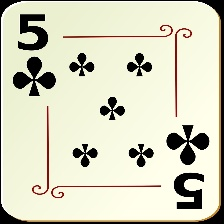

In [5]:
#Example
image, label = dataset[1200]
print(label)
image

In [6]:
# Dictionary for card class with folder names
data_dir = '/kaggle/input/cards-image-datasetclassification/train'
target_to_class = {v:k for k,v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

In [7]:
#Since all images need to be the same size, resize and convert
# into a tensor
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

data_dir = '/kaggle/input/cards-image-datasetclassification/train'
dataset = PlayingcardDataset(data_dir, transform)

In [8]:
image,label = dataset[100]
image.shape
# [RGB, X,Y]

torch.Size([3, 128, 128])

In [9]:
for image,label in dataset:
    break

## Dataloaders
* Batch the dataset
* Faster to train in batches 

In [10]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [11]:
for images,labels in dataloader:
    break

In [12]:
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

In [13]:
labels

tensor([32, 24, 16, 39, 27,  2,  3, 30,  8, 46, 22, 25, 42, 38, 16,  2, 20, 25,
        51, 52, 46,  9, 46, 20, 23, 13,  8, 52, 16, 28, 45, 24])

## PyTorch Model
There's a particular way for the dataset, pytorch models also follow a similar
* timm allows many architectures for image classification
* To understand the model, have to understand the shape of the data at each layer. The main one to identify is the final layer for the task. Since, we have 53 classes we will modify the last layer

In [14]:
class cardclassifier(nn.Module):
    def __init__(self, num_classes=53):
        super(cardclassifier, self).__init__()
        #where we define all the parts of the model
        self.base_model = timm.create_model('efficientnet_b0',pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        #model output size
        enet_out_size=1280
        #classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size,num_classes))
    
    def forward(self,x):
        #connecting the layers of the model
        x = self.features(x)
        output = self.classifier(x)
        return output

In [15]:
model = cardclassifier(num_classes=53)
print(str(model)[:500])

cardclassifier(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
 


In [16]:
example_out = model(images)
example_out.shape #batchsize, classes

torch.Size([32, 53])

## Training Loop

In [17]:
#Loss function
criterion = nn.CrossEntropyLoss()
#Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

train_folder = '/kaggle/input/cards-image-datasetclassification/train/'
valid_folder = '/kaggle/input/cards-image-datasetclassification/valid/'
test_folder = '/kaggle/input/cards-image-datasetclassification/test/'

train_dataset = PlayingcardDataset(train_folder, transform=transform)
valid_dataset = PlayingcardDataset(valid_folder, transform=transform)
test_dataset = PlayingcardDataset(test_folder, transform=transform)

#shuffle for the training dataset only
train_loader = DataLoader(train_dataset,batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset,batch_size=32,shuffle=False)
test_loader = DataLoader(test_dataset,batch_size=32, shuffle=False)

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [20]:
num_epochs = 5
train_losses, val_losses = [],[]

model = cardclassifier(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.07)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training Loop'):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc='Validation Loop'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss /len(valid_loader.dataset)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Valid loss:{val_loss}')

Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 4.559686280998078, Valid loss:3.5729837075719293


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 3.194718314367977, Valid loss:2.7847024949091783


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 2.7602438601466814, Valid loss:2.394786055582874


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 2.468090375347878, Valid loss:2.2594921633882343


Training Loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation Loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 2.2816780381537933, Valid loss:2.510423870806424


[]

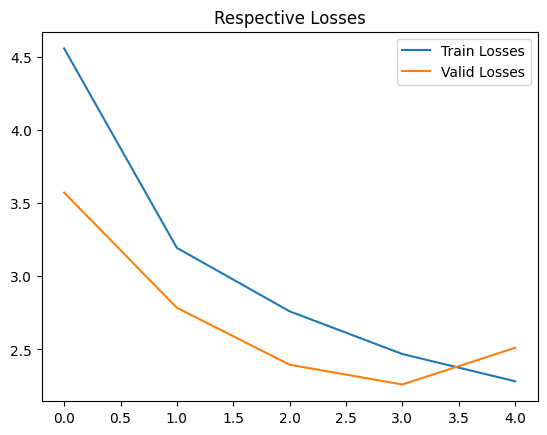

In [21]:
plt.plot(train_losses, label='Train Losses')
plt.plot(val_losses, label='Valid Losses')
plt.legend() 
plt.title("Respective Losses")
plt.plot()

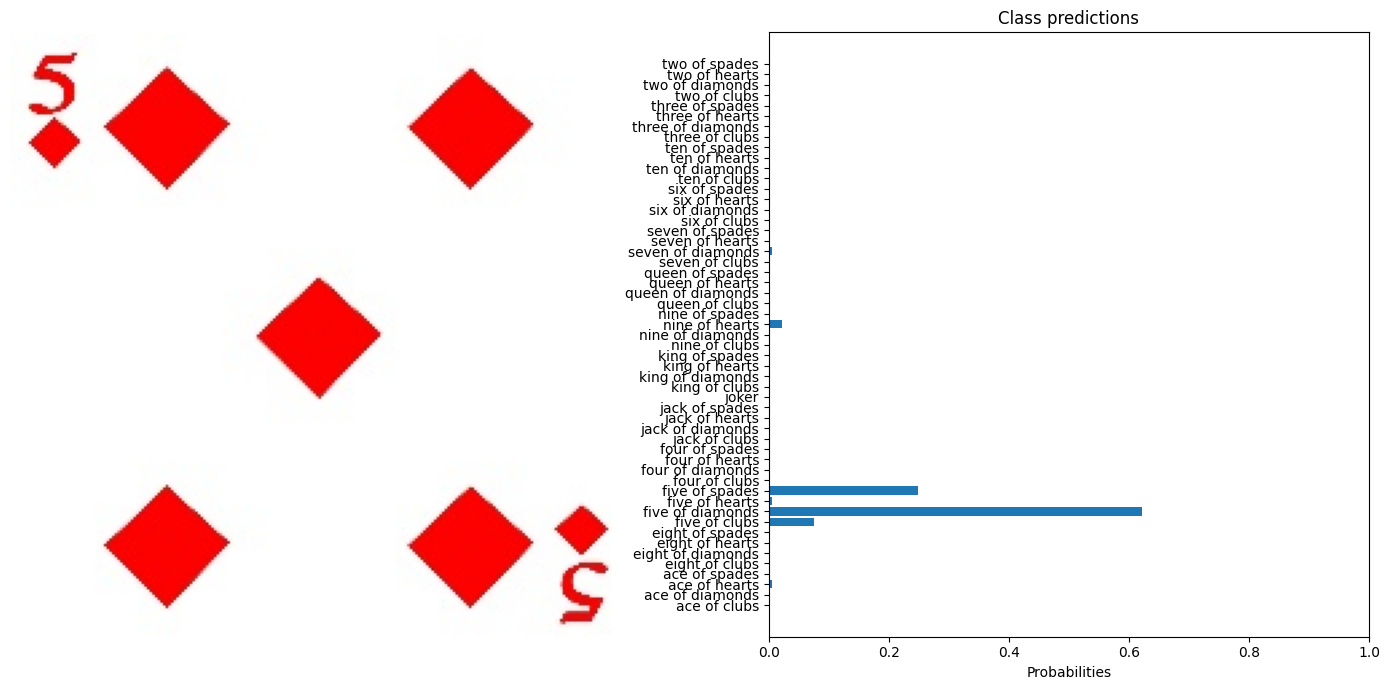

In [22]:
import torch
from PIL import Image

#load and preprocess image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    return image,transform(image).unsqueeze(0)

#predictions
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        prob = torch.nn.functional.softmax(outputs, dim=1)
    return prob.cpu().numpy().flatten()

#Visualization
def visualize_preds(orginal_image, prob, class_names):
    fig,axarr=plt.subplots(1,2, figsize=(14,7))
    
    axarr[0].imshow(original_image)
    axarr[0].axis('off')
    
    axarr[1].barh(class_names, prob)
    axarr[1].set_xlabel('Probabilities')
    axarr[1].set_title('Class predictions')
    axarr[1].set_xlim(0,1)
    
    plt.tight_layout()
    plt.show()

test_image = '/kaggle/input/cards-image-datasetclassification/test/five of diamonds/2.jpg'
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
prob = predict(model,image_tensor,device)

class_names = dataset.classes
visualize_preds(original_image, prob, class_names)

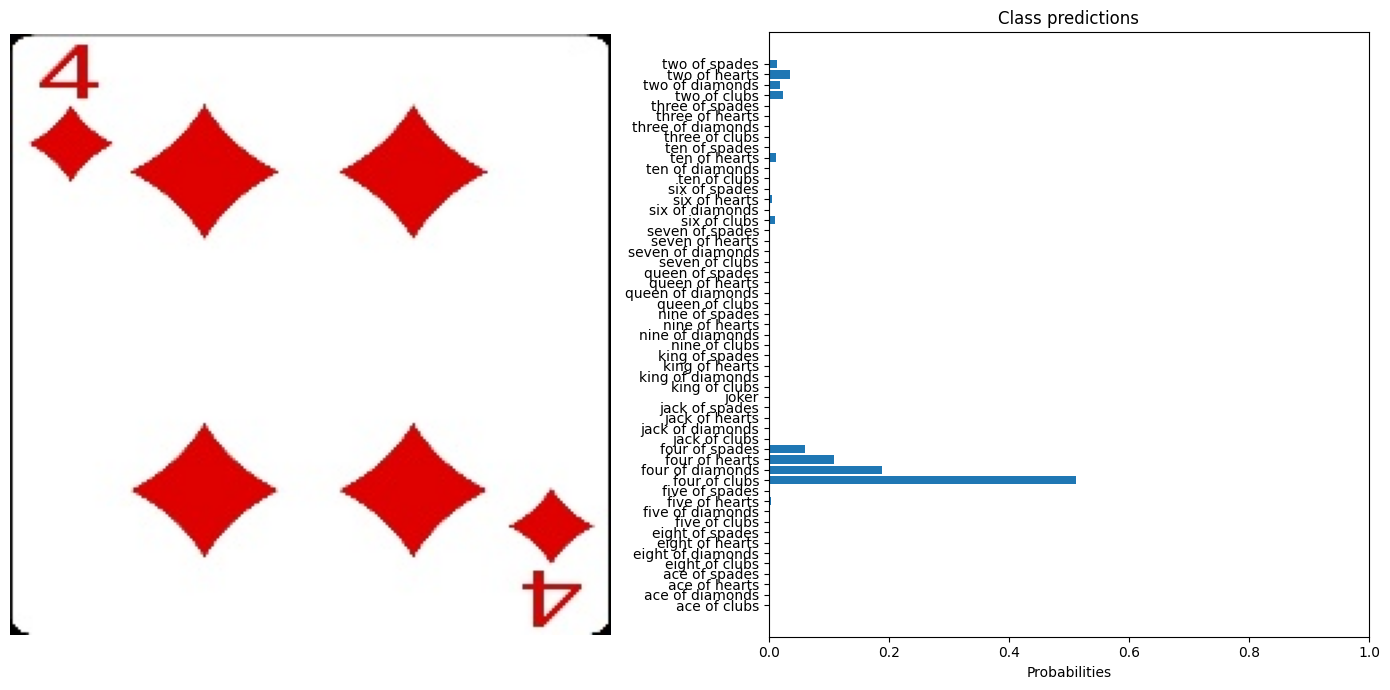

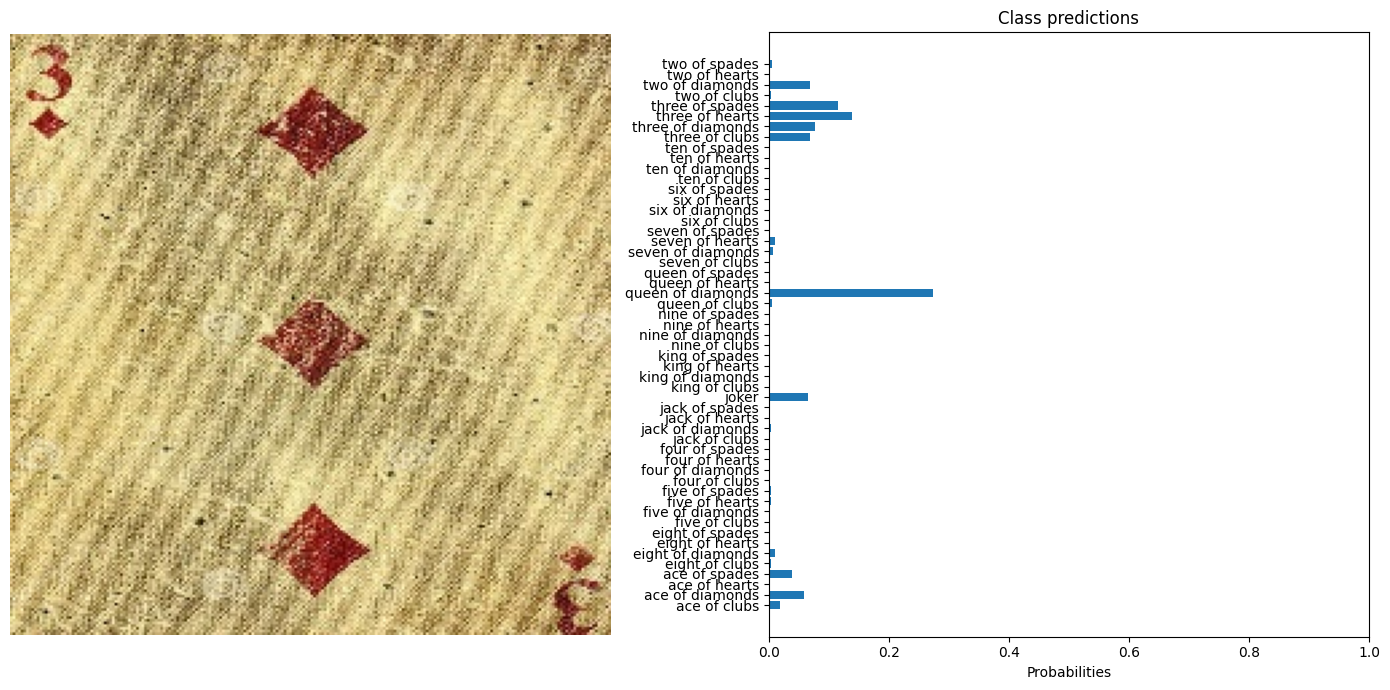

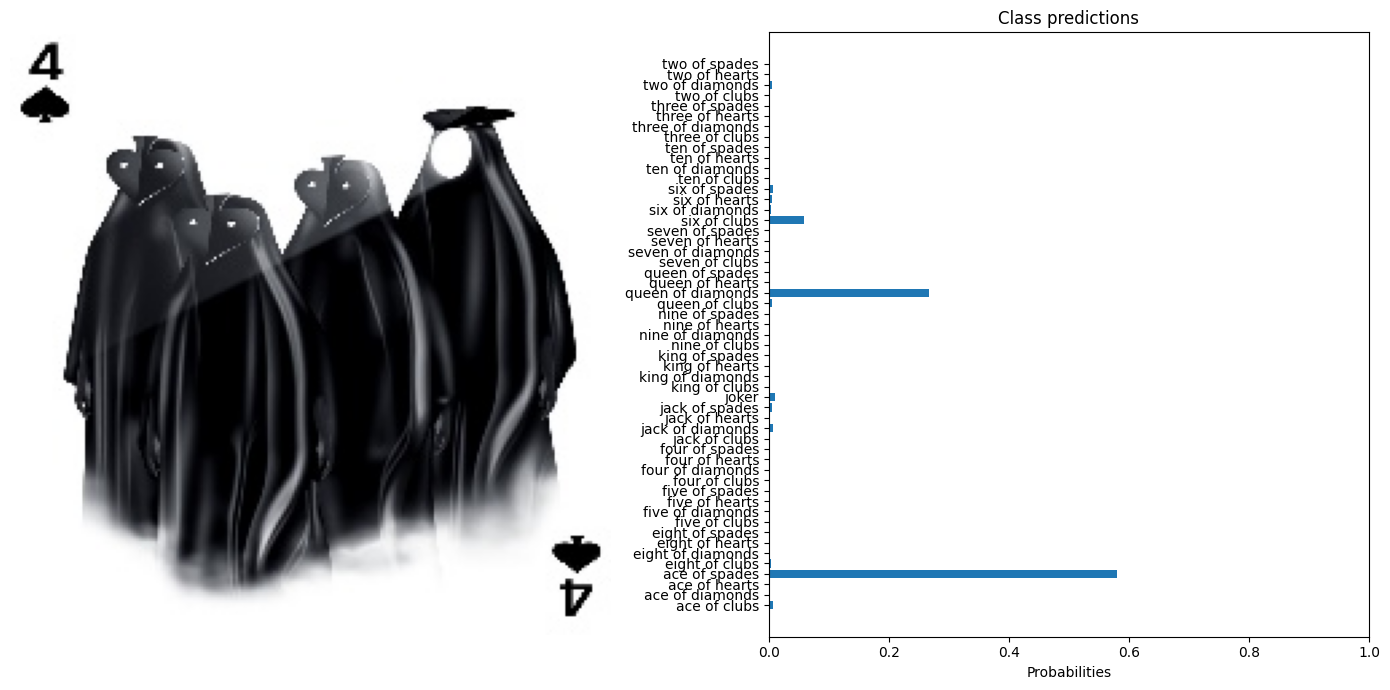

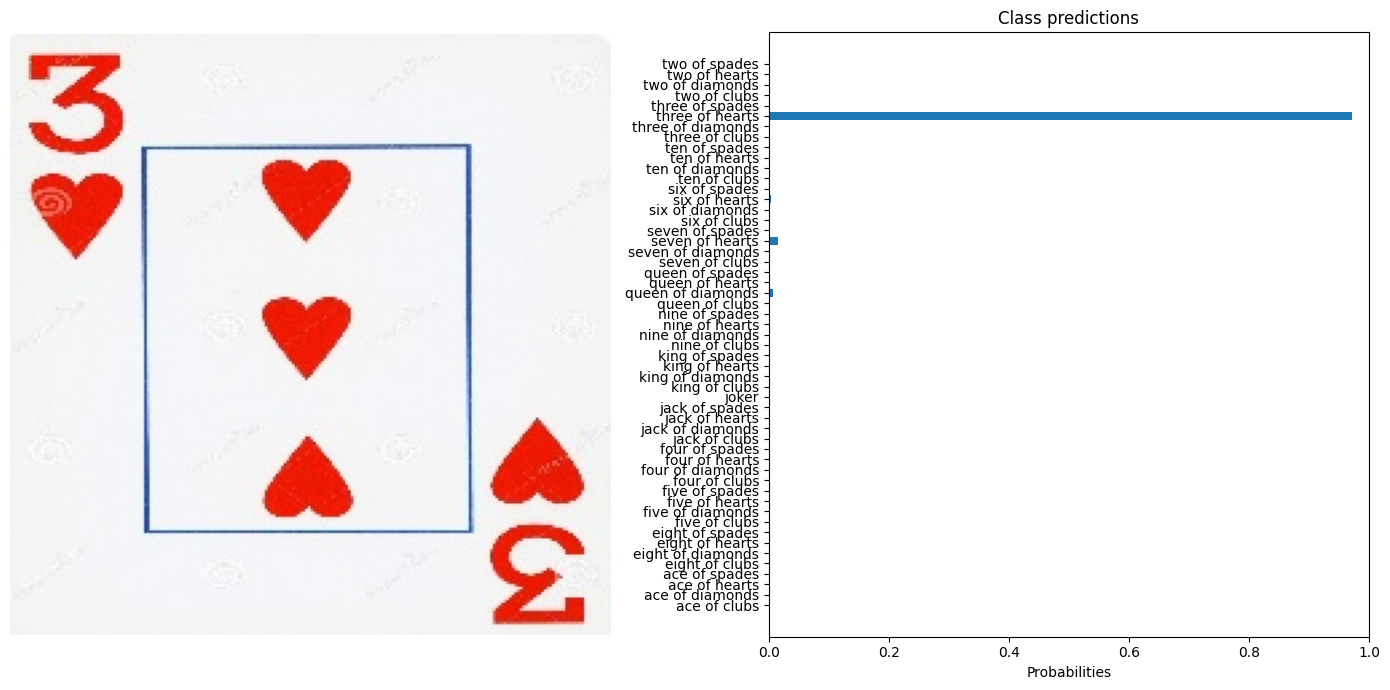

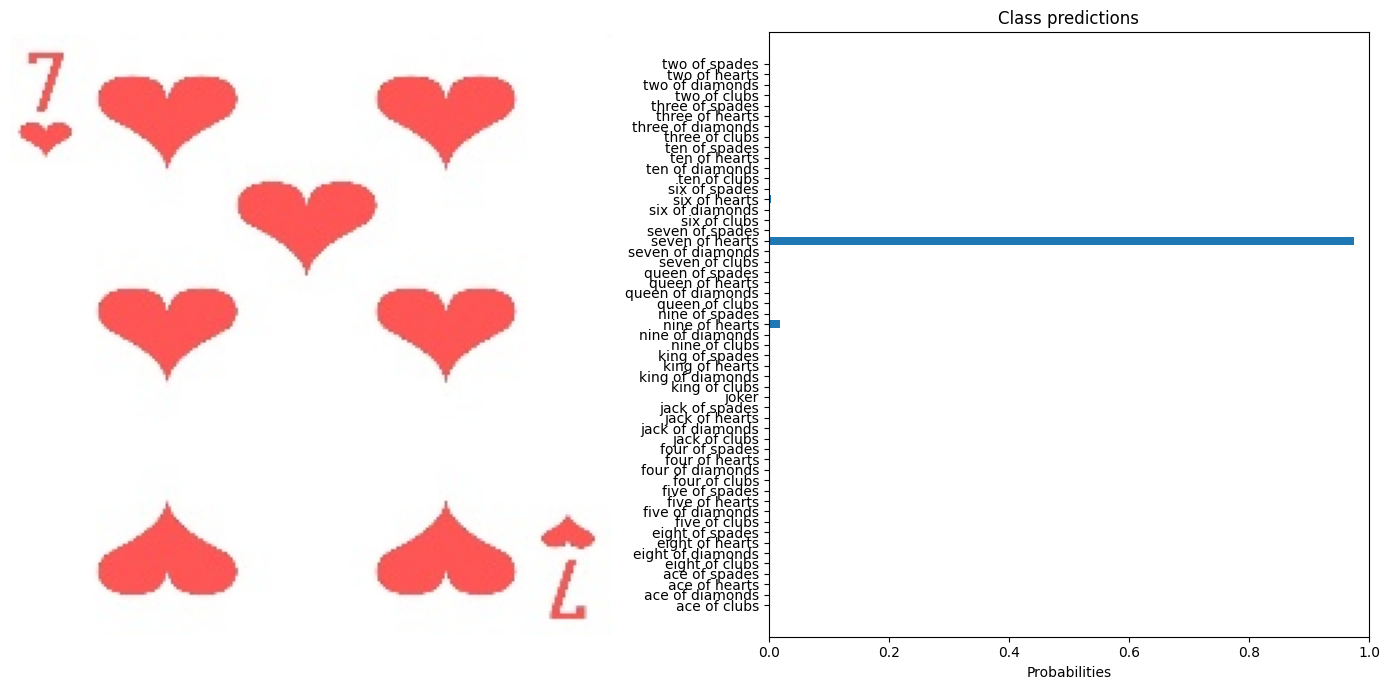

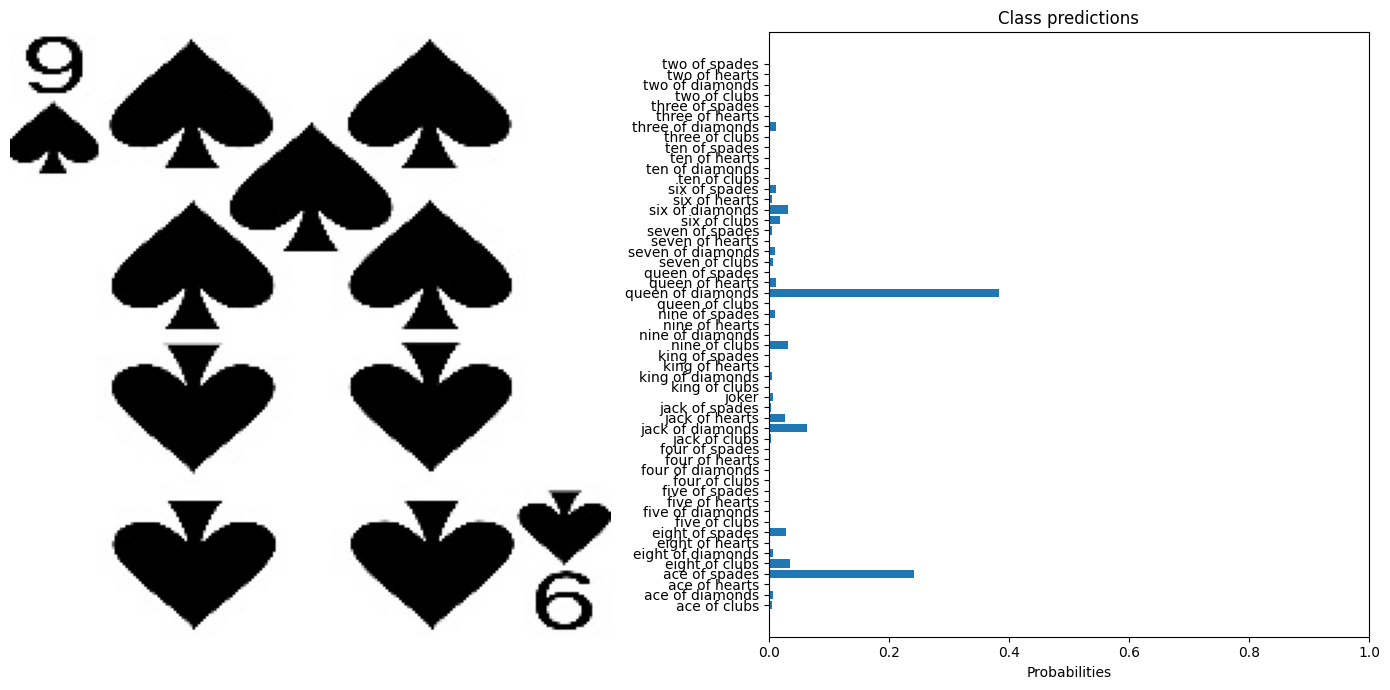

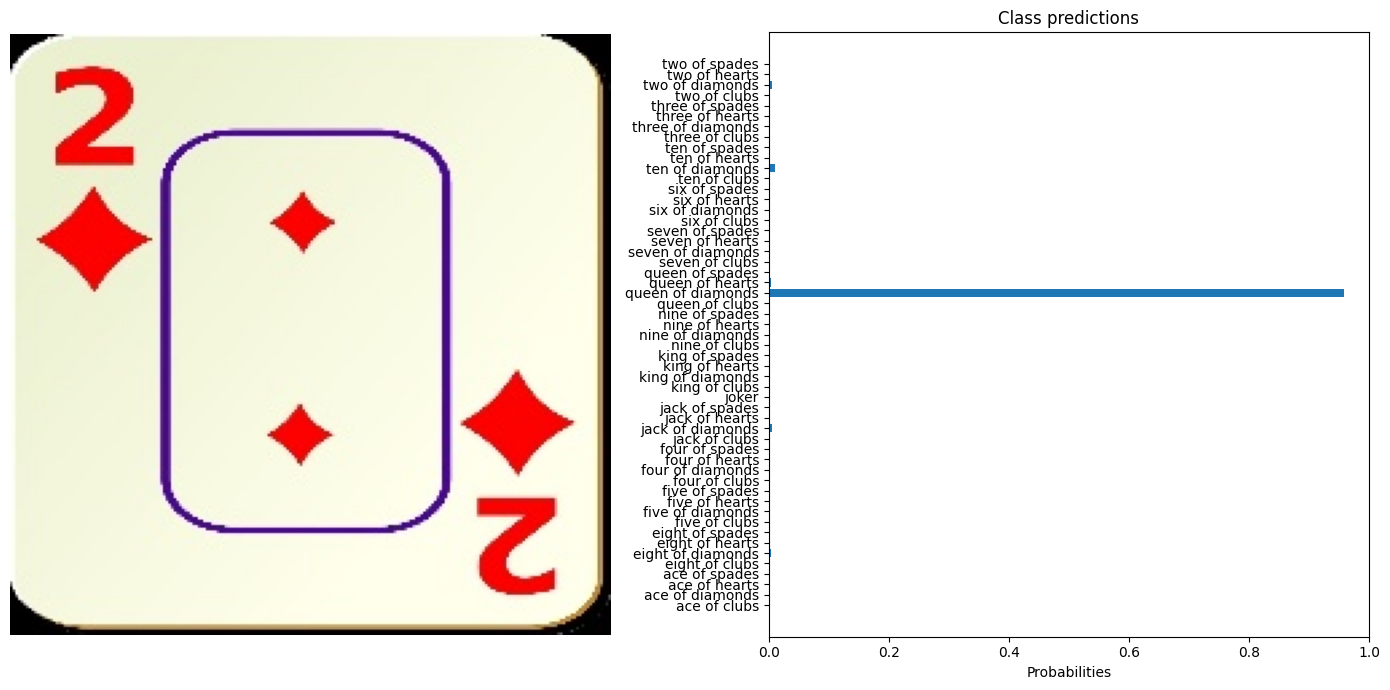

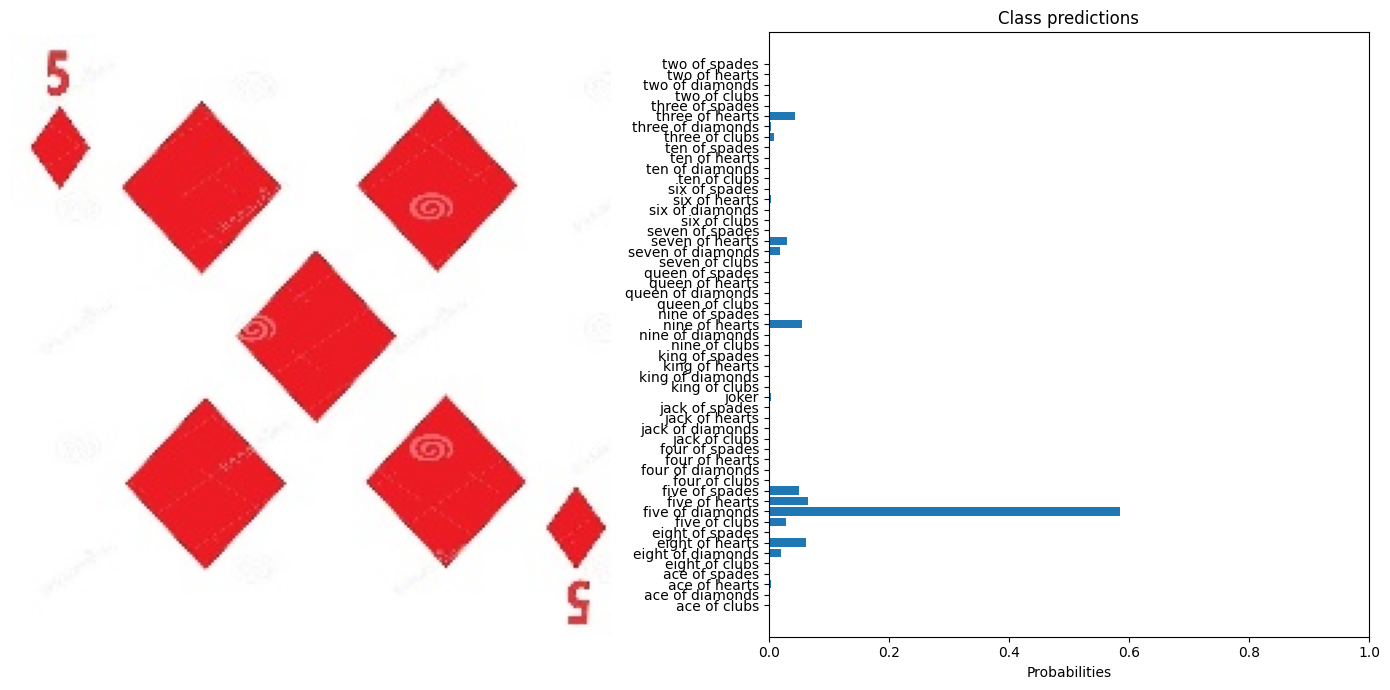

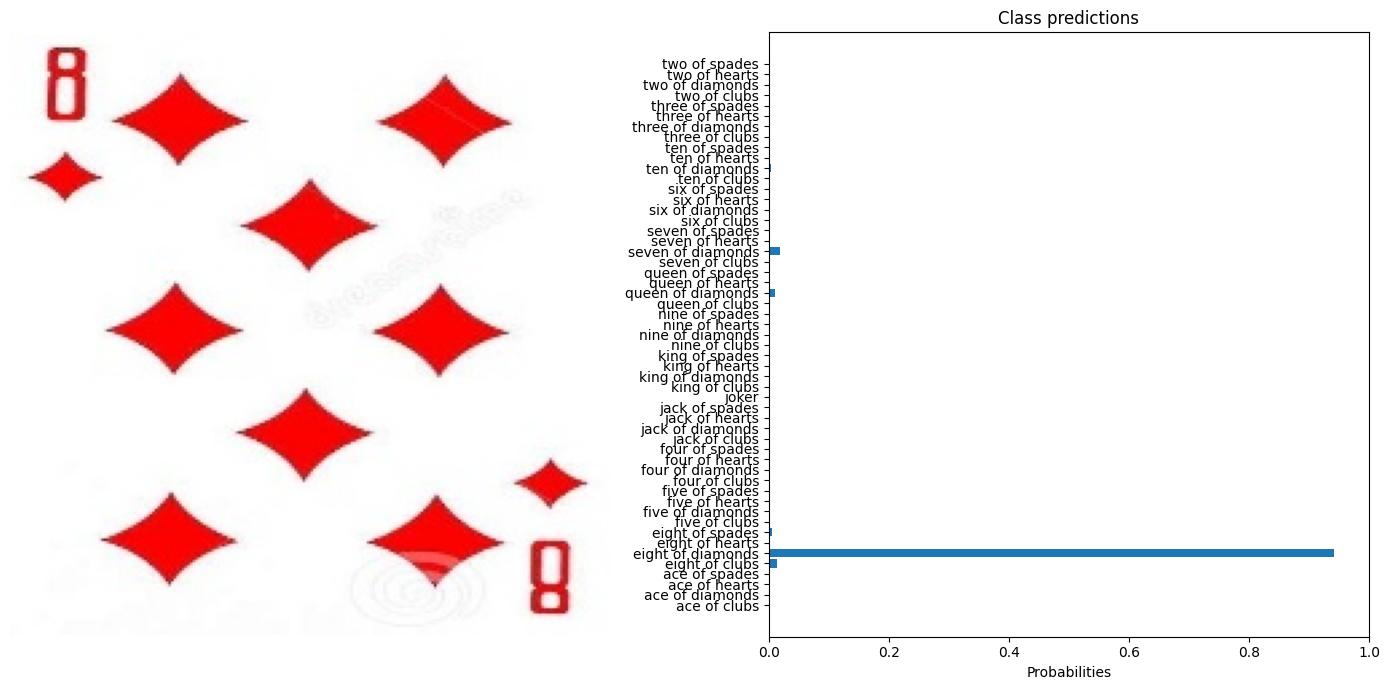

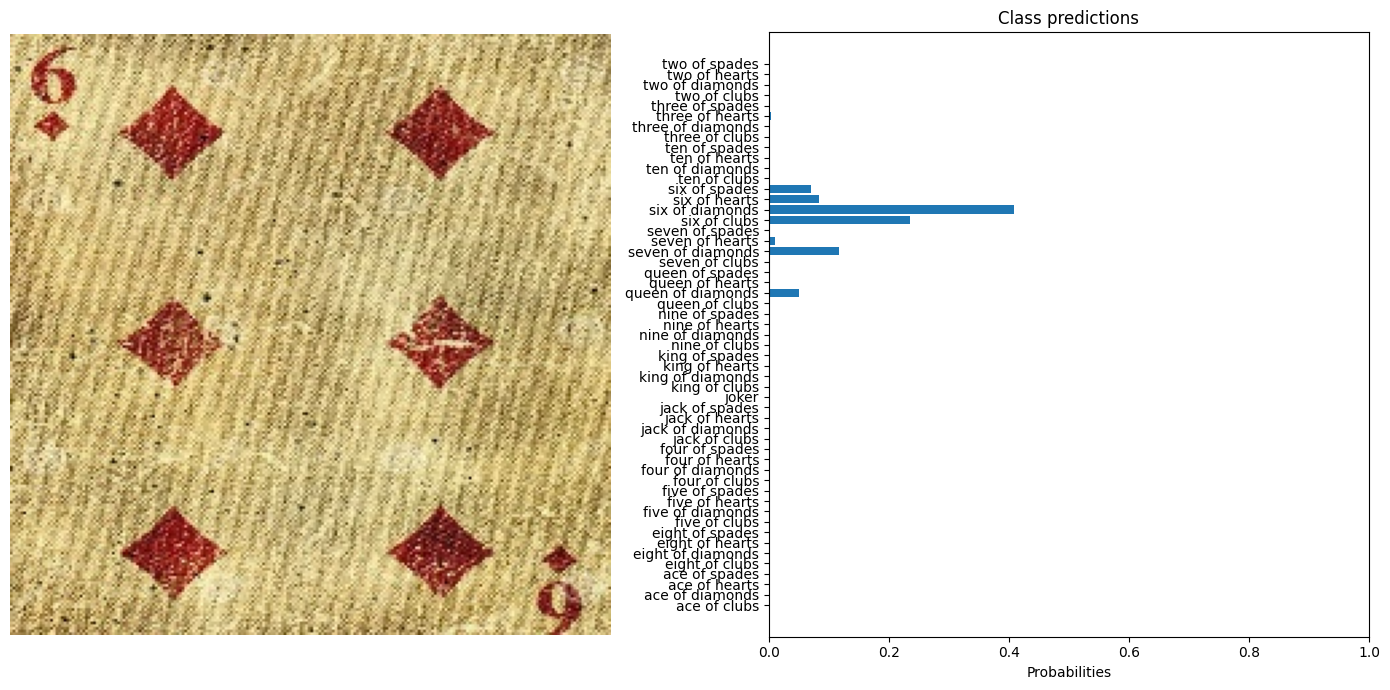

In [23]:
from glob import glob
test_images = glob("/kaggle/input/cards-image-datasetclassification/test/*/*")
test_examples = np.random.choice(test_images,10)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    prob = predict(model, image_tensor, device)
    
    class_names = dataset.classes
    visualize_preds(original_image, prob, class_names)